In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import os

import numpy as np
import pandas as pd

from gymnasium.wrappers.time_limit import TimeLimit

from dice_rl_TU_Vienna.environment import test_env
from dice_rl_TU_Vienna.dataset import get_dataset
from dice_rl_TU_Vienna.value import get_get_policy_value, get_w_prod
from dice_rl_TU_Vienna.plot.tabular import plot_pvs
from dice_rl_TU_Vienna.plot.general import plot_histogram

from dice_rl_TU_Vienna.estimators.get import get_pv_s_OnPE, get_pv_s_OffPE
from dice_rl_TU_Vienna.estimators.tabular.test import test_estimator, test_auxiliary_estimates
from dice_rl_TU_Vienna.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from dice_rl_TU_Vienna.utils.general import iterate_print
from dice_rl_TU_Vienna.utils.bedtime import computer_sleep

from plugins.gymnasium.taxi.config import *
from plugins.gymnasium.taxi.environment import Taxi

# Prepare

In [3]:
env = Taxi()
env_time_limit = TimeLimit(env, max_episode_steps)

In [4]:
policy = {
    kind: np.load( os.path.join(dir_policy[kind], "policy.npy") )
        for kind in kinds
}

get_act_uniform = lambda obs: np.random.randint(0, n_act)
get_act_policy_behavior   = lambda obs: np.random.choice( range(n_act), p=policy["behavior"]  [obs], )
get_act_policy_evaluation = lambda obs: np.random.choice( range(n_act), p=policy["evaluation"][obs], )

get_act = {
    "uniform": get_act_uniform,
    "policy": {
        "behavior": get_act_policy_behavior,
        "evaluation": get_act_policy_evaluation,
    }
}

In [5]:
dataset     = {}
id_dataset  = {}
dir_dataset = {}

up = "uniform"

x, y = get_dataset(
    dir_base,
    env_time_limit,
    get_act[up],
    {
        "seed": seed,
        "n_trajectories": n_trajectories,
        "max_episode_steps": max_episode_steps,
    },
    verbosity=1,
)

dataset    [up] = x
id_dataset [up] = y
dir_dataset[up] = os.path.join(dir_base, y)

up = "policy"
dataset    [up] = {}
id_dataset [up] = {}
dir_dataset[up] = {}

for kind in kinds:

    x, y = get_dataset(
        dir_policy[kind],
        env_time_limit,
        get_act[up][kind],
        {
            "seed": seed,
            "n_trajectories": n_trajectories,
            "max_episode_steps": max_episode_steps,
        },
        verbosity=1,
    )

    dataset    [up][kind] = x
    id_dataset [up][kind] = y
    dir_dataset[up][kind] = os.path.join(dir_policy[kind], y)

get_probs = lambda obs, policy: policy[obs]

for kind in kinds:

    probs_init = list( get_probs(dataset["policy"][kind]["obs_init"], policy["evaluation"]) )
    probs_next = list( get_probs(dataset["policy"][kind]["obs_next"], policy["evaluation"]) )

    dataset["policy"][kind]["probs_init"] = probs_init
    dataset["policy"][kind]["probs_next"] = probs_next

trying to find id_dataset in data/gymnasium/taxi/dataset.json
trying to load dataset from data/gymnasium/taxi/2025-02-12T14:45:13.419270/dataset.parquet
trying to find id_dataset in data/gymnasium/taxi/2025-02-12T13:21:21.067254/dataset.json
trying to load dataset from data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/dataset.parquet
trying to find id_dataset in data/gymnasium/taxi/2025-02-12T13:23:07.487448/dataset.json
trying to load dataset from data/gymnasium/taxi/2025-02-12T13:23:07.487448/2025-02-12T14:45:16.371242/dataset.parquet


In [6]:
estimators_OnPE = {}

for kind in kinds:
    estimators_OnPE[kind] = get_get_policy_value(dataset["policy"][kind])
    estimators_OnPE[kind].__name__ = f"OnPE {kind}"

In [7]:
estimators_OffPE = {}
estimators_VAFE  = {}
estimators_DICE  = {}

for kind in iterate_print(kinds, "kind"):
    E = [
        estimator_type(
            dataset["policy"][kind],
            n_obs, n_act,
            dir_dataset["policy"][kind],
            verbosity=1,
        )
            for estimator_type in [
                TabularVafe, TabularDice, TabularDualDice, TabularGradientDice, ]
    ]

    estimators_OffPE[kind] = E
    estimators_VAFE [kind] = E[:1]
    estimators_DICE [kind] = E[1:]

kind=behavior
trying to load auxiliary estimates from data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/d0_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/dD_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/P_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/r_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/n.npy
trying to load auxiliary estimates from data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/d0_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/dD_bar.npy
loaded data/gymnasium/taxi/2025-02-12T13:21:21.067254/2025-02-12T14:45:14.921127/P_bar.npy
loaded data/gymnasium/taxi/202

In [14]:
probs = {
    kind: get_probs(dataset["policy"]["behavior"]["obs"], policy[kind])
        for kind in kinds
}

x = np.array(probs["evaluation"])
y = np.array(probs["behavior"])
z = np.array(dataset["policy"]["behavior"]["act"])

IS_weights = x[np.arange(len(z)), z] / y[np.arange(len(z)), z]

f = get_get_policy_value(dataset["policy"]["behavior"], IS_weights)
g = lambda gamma: f(gamma, weighted=False)
g.__name__ = "SIS"
h = lambda gamma: f(gamma, weighted=True)
h.__name__ = "WIS"

estimators_IS = { False: g, True: h, }

# `get_pvs`

In [19]:
pvs_OnPE = {
    kind: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[kind],
        gamma_s=gammas,
    )
        for kind in kinds
}

In [20]:
pv_OnPE = {
    kind: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[kind],
        gamma_s=1.0,
    )
        for kind in kinds
}

In [21]:
pvs_VAFE = {}
pvs_DICE = { kind: {} for kind in kinds }

for kind in kinds:
    dir = dir_dataset["policy"][kind]

    file = os.path.join(dir, "pvs_VAFE.npy")

    if os.path.exists(file):
        arr = np.load(file)
    else:
        arr = get_pv_s_OffPE(
            estimator_s=estimators_VAFE[kind],
            gamma_s=gammas,
            projected=projected, weighted=None,
            modified=modified, lamda=lamda,
            verbosity=2,
        )
        np.save(file, arr)

    pvs_VAFE[kind] = arr

    for weighted, postfix in zip([False, True], ["simple", "weighted"]):

        file = os.path.join(dir, f"pvs_DICE_{postfix}.npy")

        if os.path.exists(file):
            arr = np.load(file)
        else:
            arr = get_pv_s_OffPE(
                estimators_DICE[kind],
                gammas,
                projected=projected, weighted=weighted,
                modified=modified, lamda=lamda,
                verbosity=2,
            )
            np.save(file, arr)

        pvs_DICE[kind][weighted] = arr

In [22]:
pvs_IS = {
    weighted: get_pv_s_OnPE(
        estimator_s=estimators_IS[weighted],
        gamma_s=gammas,
    )
        for weighted in [False, True]
}

In [23]:
pv_DICE = { kind: {} for kind in kinds }

for kind in kinds:
    for weighted, postfix in zip([False, True], ["simple", "weighted"]):
        dir = dir_dataset["policy"][kind]

        file = os.path.join(dir, f"pv_DICE_{postfix}.npy")

        if os.path.exists(file):
            arr = np.load(file)
        else:
            arr, *_ = estimators_DICE[kind][0].solve(
                gamma=1.0, projected=projected, weighted=weighted, modified=modified,
            )
            np.save(file, arr)

        pv_DICE[kind][weighted] = arr

# Plot

## Policy Values

In [24]:
def plot_pvs_taxi(kind, weighted, errors):

    estimators = []
    if not errors: estimators += [ estimators_OnPE[kind] for kind in kinds ]
    estimators += estimators_OffPE[kind]
    if kind == "behavior": estimators += [ estimators_IS[w] for w in [False, True] ]
    pvs = []
    if not errors: pvs += [ pvs_OnPE[kind] for kind in kinds ]
    pvs += list(pvs_VAFE[kind]) + list(pvs_DICE[kind][weighted])
    if kind == "behavior": pvs += [ pvs_IS[w] for w in [False, True] ]
    pv_ref = pvs_OnPE["evaluation"]
    pv_lims = []
    if not errors: pv_lims += [ pv_OnPE[kind] for kind in kinds ]
    pv_lims.append(pv_DICE[kind][weighted])
    pv_lim_ref = pv_OnPE["evaluation"]
    labels = None
    c  = []
    if not errors: c += colors_OnPE
    c += colors_OffPE
    if kind == "behavior": c += colors_IS
    cl = []
    if not errors: cl += colors_lim_OnPE
    cl += colors_lim_OffPE
    m  = []
    if not errors: m += markers_OnPE
    m += markers_OffPE
    if kind == "behavior": m += markers_IS
    ml = []
    if not errors: ml += markers_lim_OnPE
    ml += markers_lim_OffPE
    measure = "PV Errors" if errors else "PVs"
    suptitle = f"{env_title} - {kind} dataset - {measure}"
    a = r"\hat{\rho}^\pi_\text{OffPE}(\gamma)"
    b = r"\hat{\rho}^\pi_\text{OnPE}(\gamma)"
    one_minus_gamma = True
    xlabel = None
    ylabel = None if not errors else f"$| {a} - {b} |$"
    scale_x = True
    scale_y = errors
    scale_pv = False
    ylim = None
    legend = True
    dir = dir_images

    plot_pvs(
        estimators,
        gammas,
        projected, weighted,
        modified, lamda,
        #
        pvs, pv_lims, pv_ref, pv_lim_ref,
        labels,
        c, cl,
        m, ml,
        suptitle,
        one_minus_gamma, errors,
        xlabel, ylabel,
        scale_x, scale_y,
        scale_pv,
        ylim, legend,
        dir,
    )

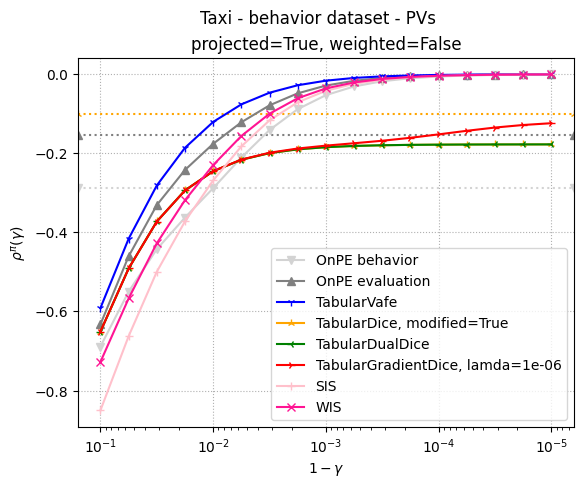

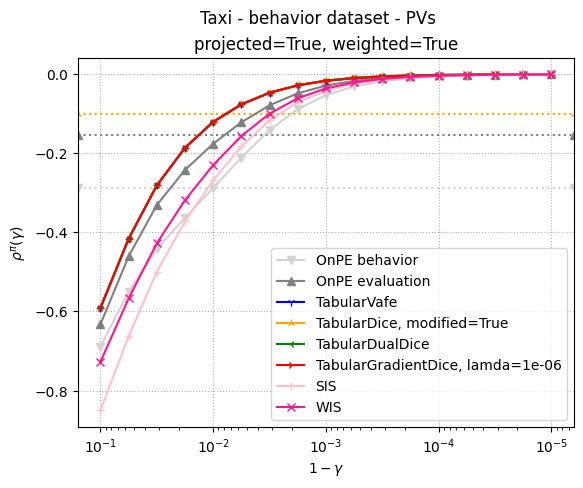

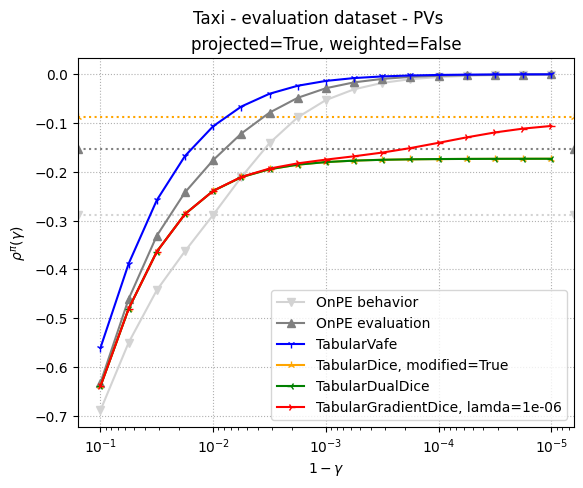

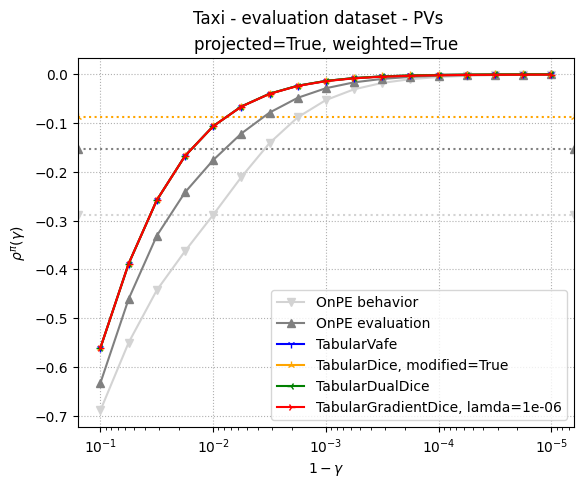

In [25]:
for kind in kinds:
    plot_pvs_taxi(kind, weighted=False, errors=False)
    plot_pvs_taxi(kind, weighted=True,  errors=False)

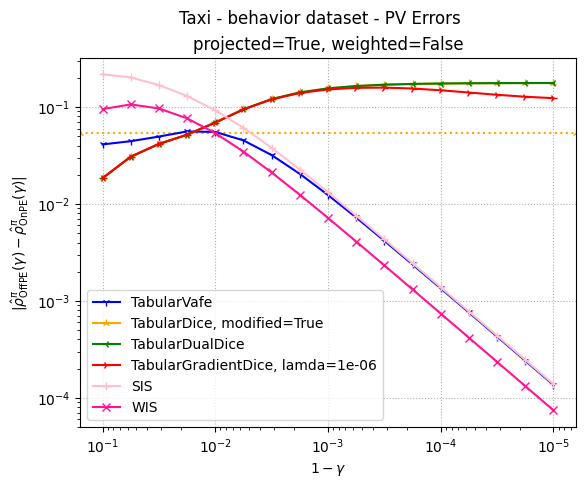

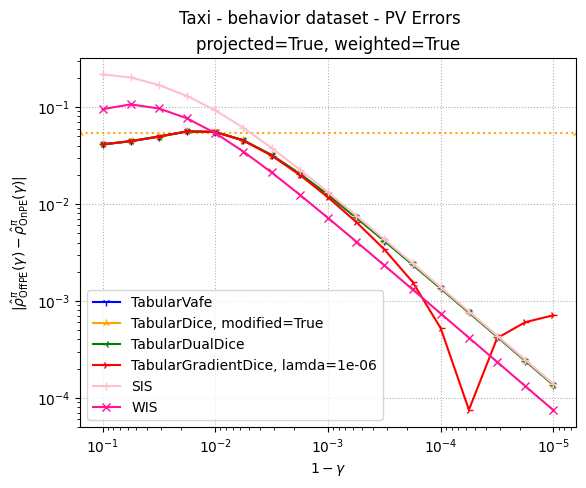

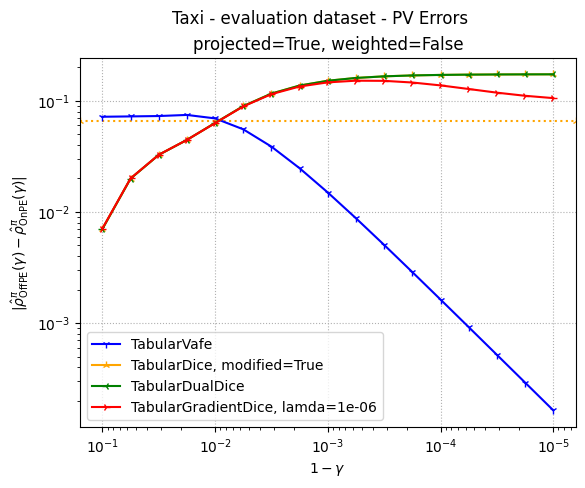

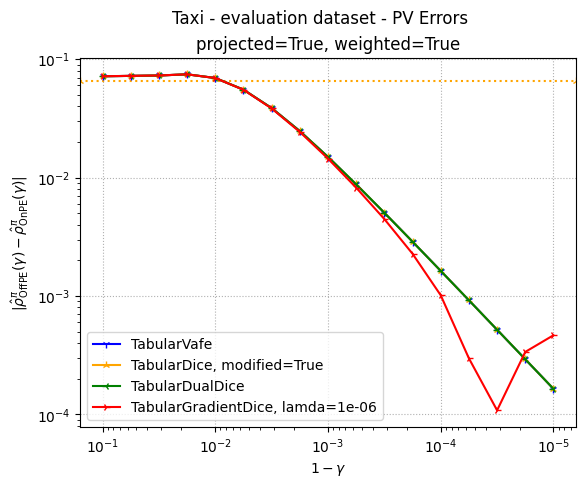

In [26]:
for kind in kinds:
    plot_pvs_taxi(kind, weighted=False, errors=True)
    plot_pvs_taxi(kind, weighted=True,  errors=True)

# Test

## Classical Importance Sampling

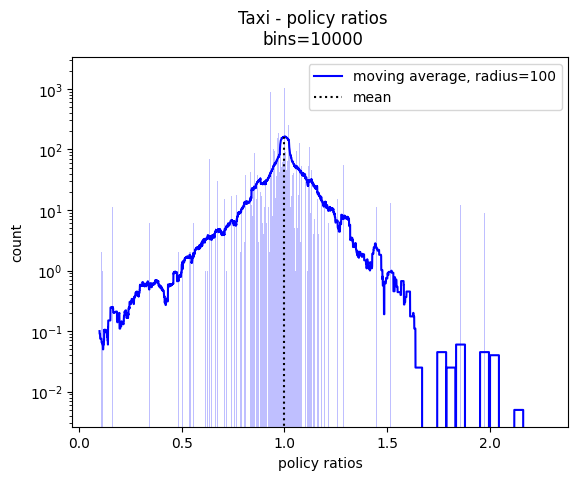

In [72]:
plot_histogram(
    data=IS_weights,
    bins=10_000, moving_average_radius=100,
    suptitle="Taxi - policy ratios", xlabel="policy ratios",
    yscale=True,
)

In [31]:
IS_weights_prod = get_w_prod(dataset["policy"]["behavior"], IS_weights)

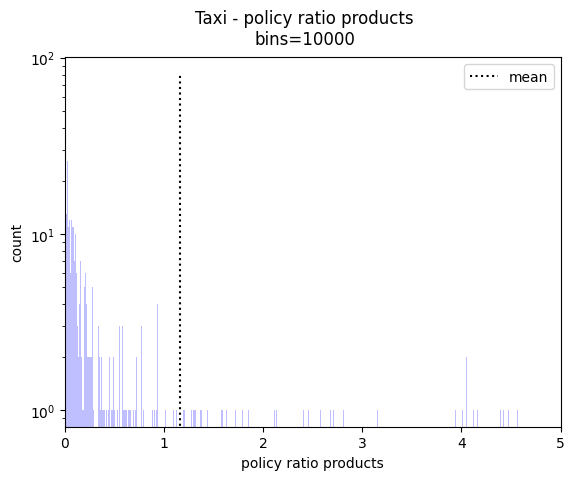

In [76]:
plot_histogram(
    data=IS_weights_prod,
    bins=10_000,
    suptitle="Taxi - policy ratio products",
    xlabel="policy ratio products",
    xlim=[0, 5],
    yscale=True
)

## Estimators

(s, a) visited:
{'absolute': 7789, 'relative': 0.6490833333333333}
(s, a) not visited:
{'absolute': 4211, 'relative': 0.35091666666666665}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 15288
# dD_bar[i], but d0_bar[i] != 0: 25

# ---------------------------------------------------------------- # 



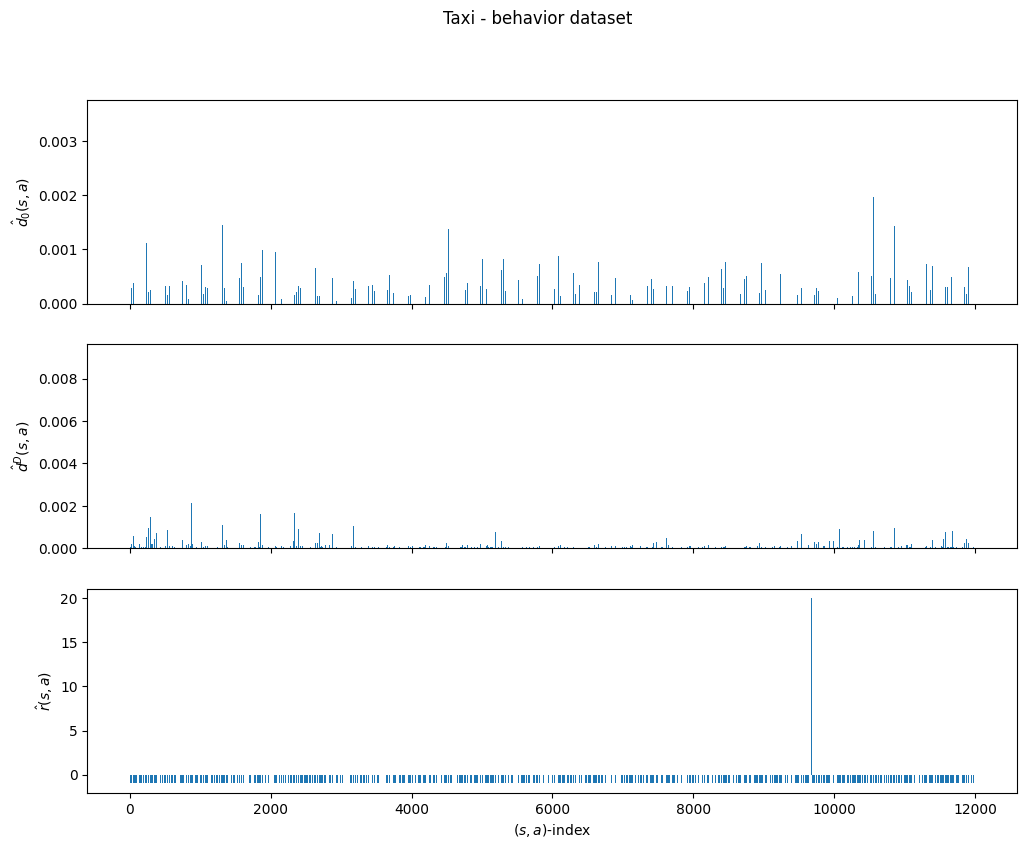

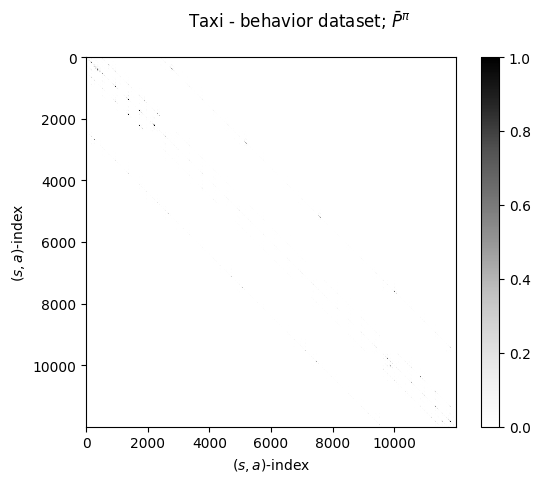

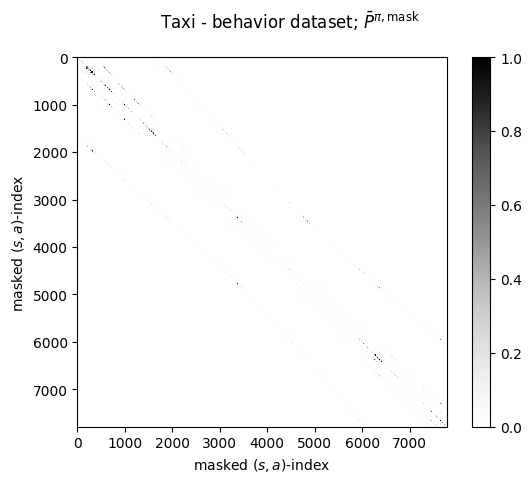

# ---------------------------------------------------------------- # 



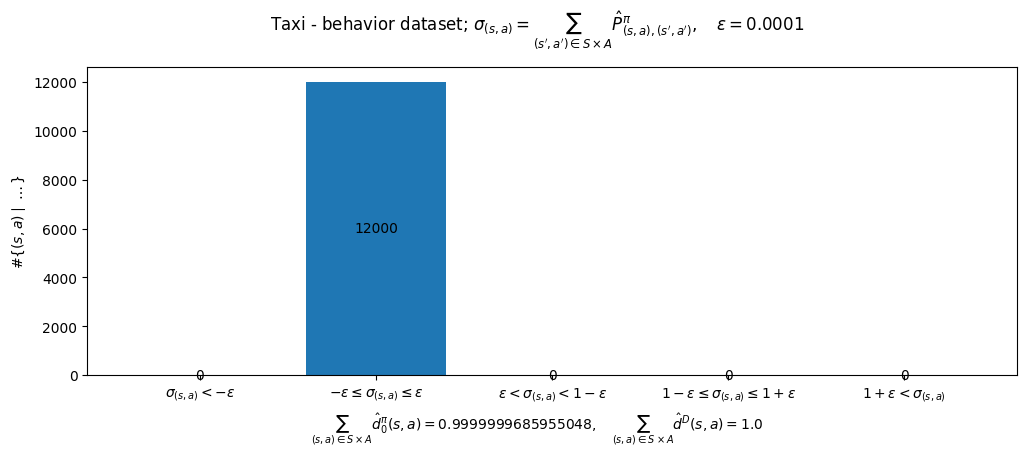

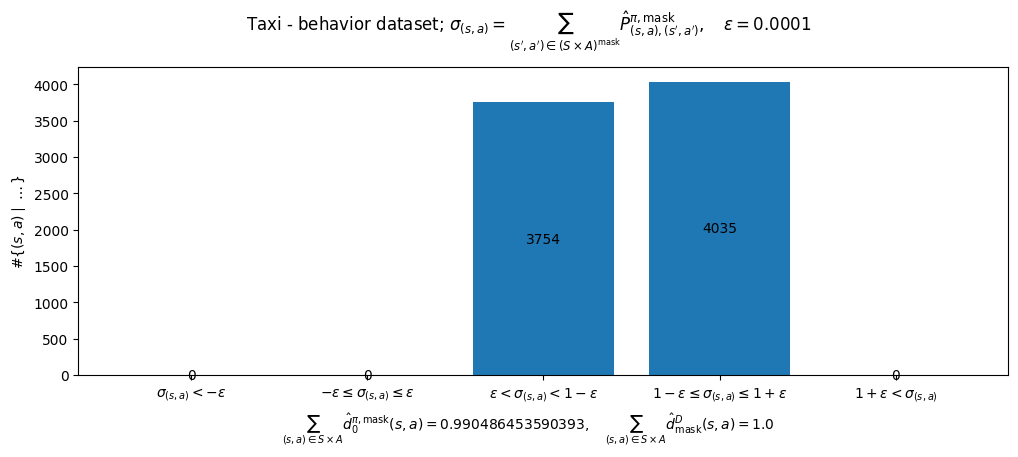

# ---------------------------------------------------------------- # 



In [186]:
k = "b"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[kind],
    title_prefix=f"Taxi - {names[kind]} dataset",
    save_dir=os.path.join(save_dir_images, "auxiliary_estimates"),
)

(s, a) visited:
{'absolute': 7373, 'relative': 0.6144166666666667}
(s, a) not visited:
{'absolute': 4627, 'relative': 0.38558333333333333}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 17067
# dD_bar[i], but d0_bar[i] != 0: 37

# ---------------------------------------------------------------- # 



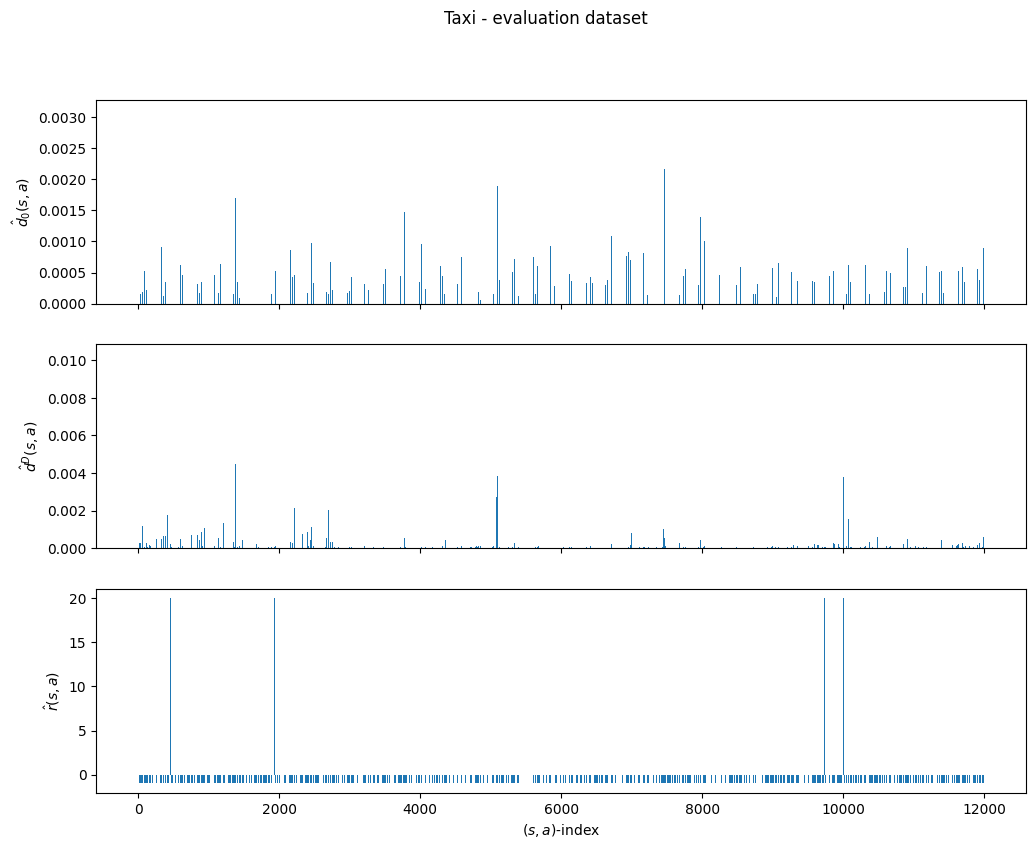

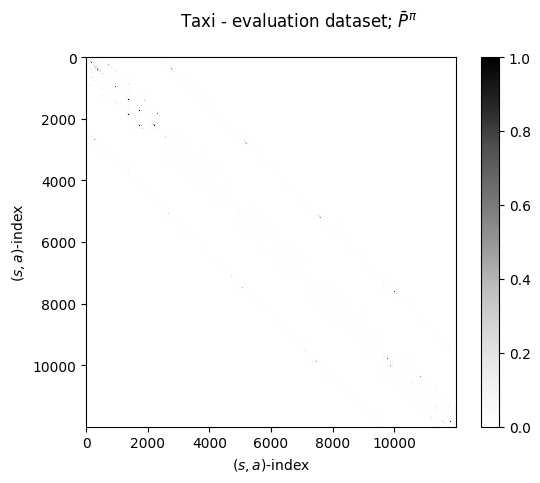

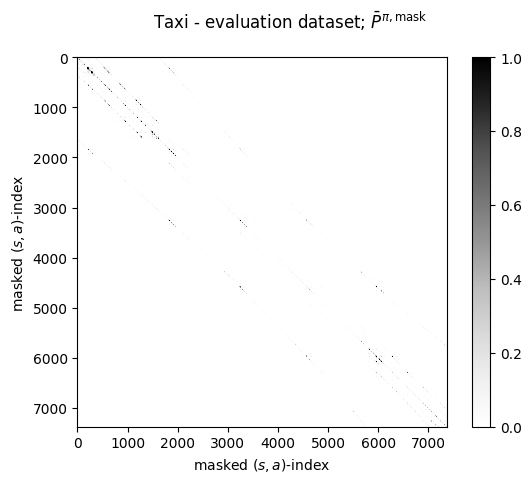

# ---------------------------------------------------------------- # 



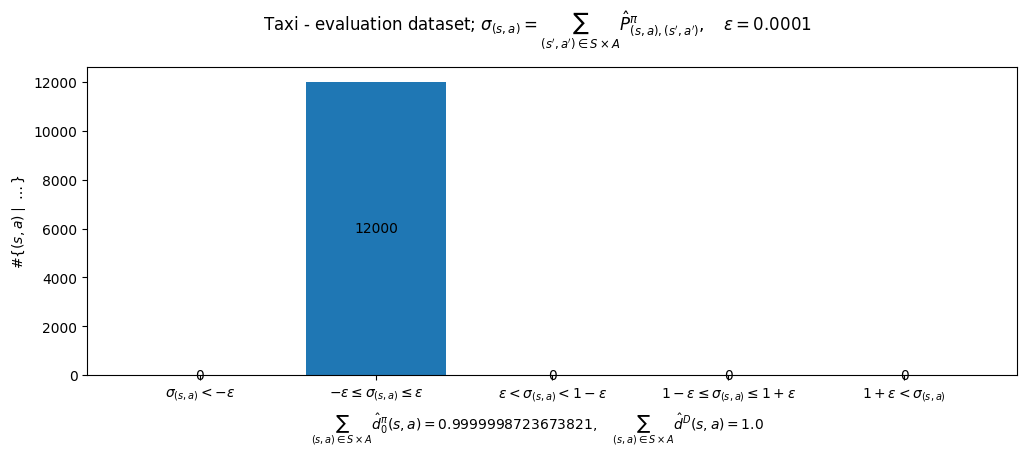

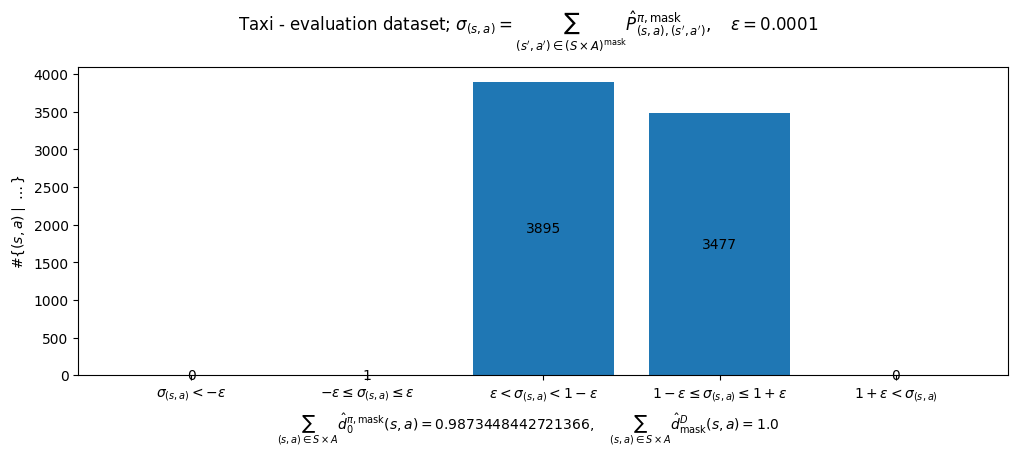

# ---------------------------------------------------------------- # 



In [187]:
k = "e"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[kind],
    title_prefix=f"Taxi - {names[kind]} dataset",
    save_dir=os.path.join(save_dir_images, "auxiliary_estimates"),
)

pv=-0.6440832018852234
np.dot(sdc_hat, dD_hat)=0.9265472966441386



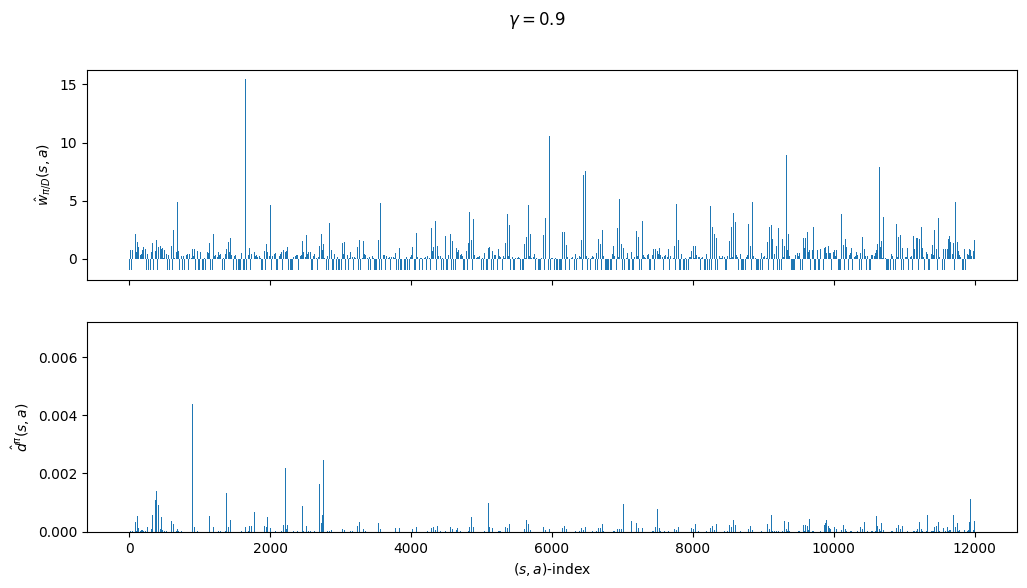

In [184]:
k = "b"

test_estimator(
    estimator_DICE=estimators_DICE[kind][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

pv=-0.6495311856269836
np.dot(sdc_hat, dD_hat)=0.9074036191783112



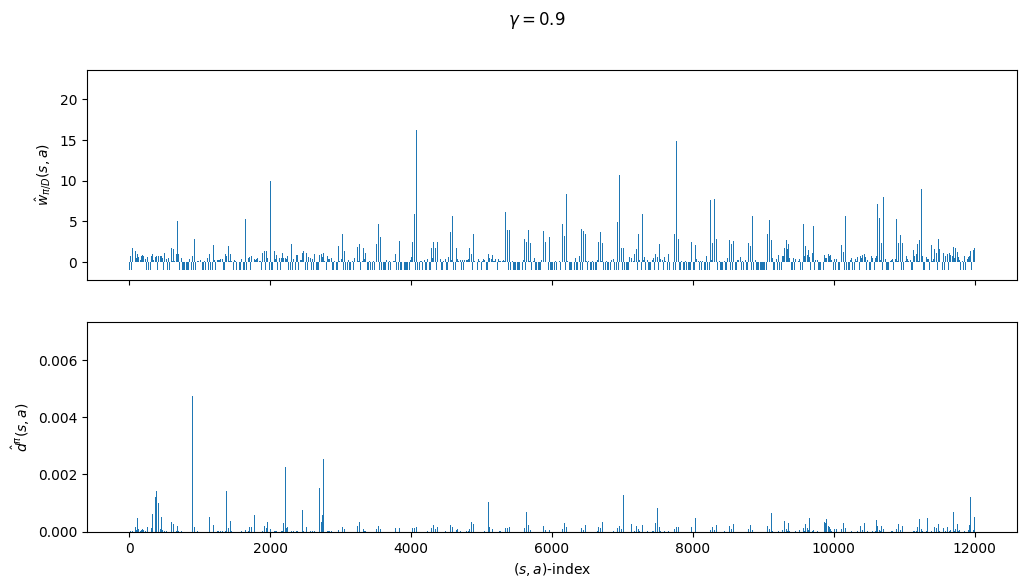

In [185]:
k = "e"

test_estimator(
    estimator_DICE=estimators_DICE[kind][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)